# This is an slightly modified and significantly abbreviated version of the Seurat - Guided Clustering Tutorial 
(https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html)

## Setup

In [1]:
install.packages(c("Seurat", "scico"), Ncpus = 2)

also installing the dependencies ‘desc’, ‘pkgbuild’, ‘rprojroot’, ‘pkgload’, ‘praise’, ‘rlang’, ‘bitops’, ‘testthat’, ‘gtools’, ‘caTools’, ‘sitmo’, ‘globals’, ‘listenv’, ‘isoband’, ‘crosstalk’, ‘gplots’, ‘gridExtra’, ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘goftest’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggplot2’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘ROCR’, ‘rsvd’, ‘Rtsne’, ‘sctransform’, ‘spatstat’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’



In [91]:
system("wget https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")
system("tar -xvf pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [92]:
library(dplyr)
library(Seurat)
library(patchwork)

In [93]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [94]:
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA
AAACATACAACCAC-1,pbmc3k,2419,779
AAACATTGAGCTAC-1,pbmc3k,4903,1352
AAACATTGATCAGC-1,pbmc3k,3147,1129
AAACCGTGCTTCCG-1,pbmc3k,2639,960
AAACCGTGTATGCG-1,pbmc3k,980,521


In [95]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

## Visualize features

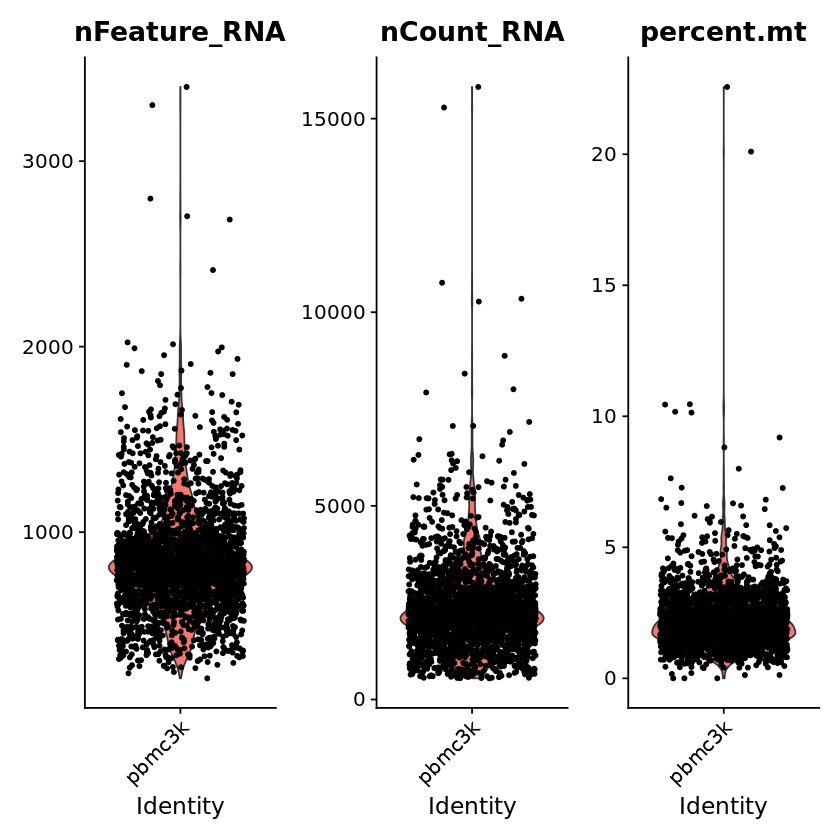

In [96]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

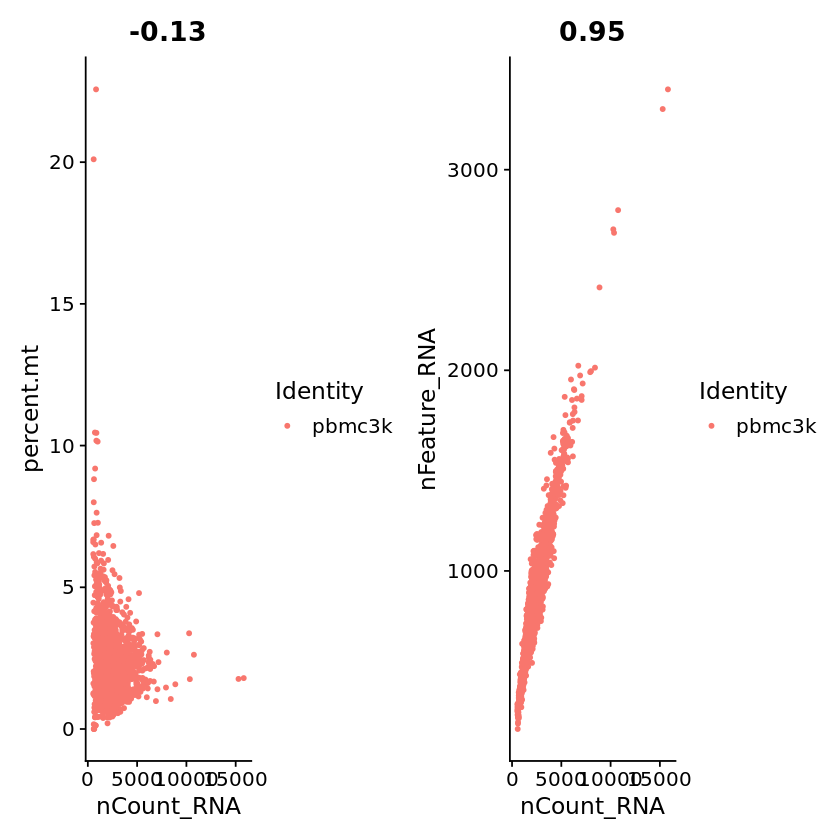

In [97]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

## Filter and normalize data

In [98]:
pbmc.filt <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [99]:
pbmc.filt.norm <- NormalizeData(pbmc.filt, normalization.method = "LogNormalize", scale.factor = 10000)

## Feature selection

In [100]:
pbmc.filt.norm <- FindVariableFeatures(pbmc.filt.norm, selection.method = "vst", nfeatures = 2000)

In [101]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc.filt.norm), 10)

In [102]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc.filt.norm)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge = 0, ynudge = 0)

Warning message:
“Transformation introduced infinite values in continuous x-axis”

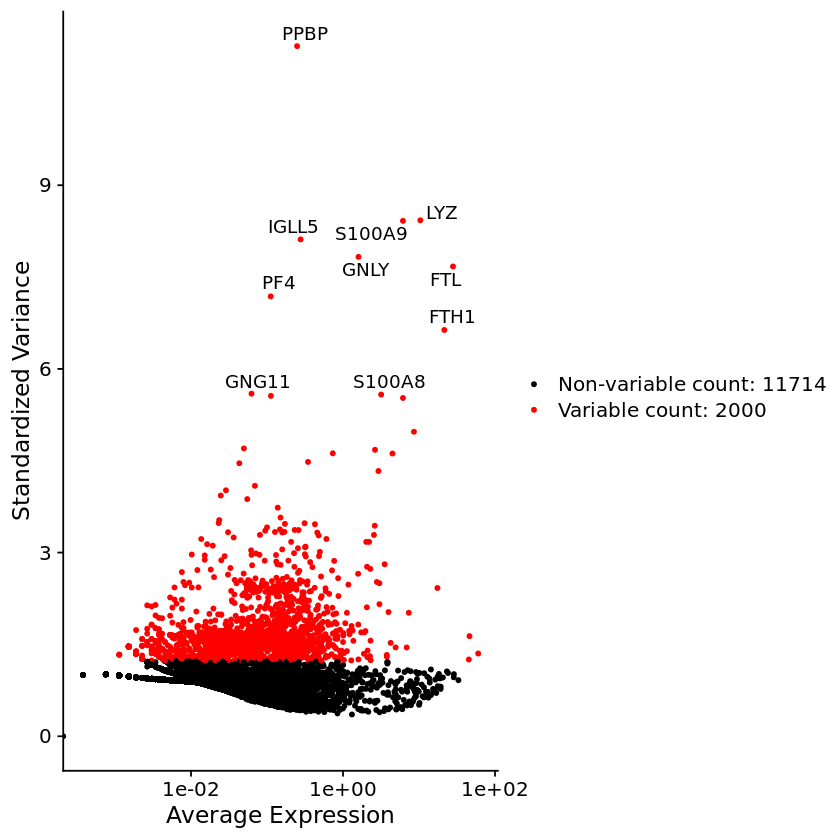

In [103]:
plot2

## Scaling the data

In [104]:
#scale data for PCA
all.genes <- rownames(pbmc.filt.norm)
pbmc.filt.norm.scaled <- ScaleData(pbmc.filt.norm, features = all.genes)

Centering and scaling data matrix


## Perform linear dimensional reduction

In [105]:
pbmc.filt.norm.scaled.PCA <- RunPCA(pbmc.filt.norm.scaled, features = VariableFeatures(object = pbmc.filt.norm.scaled))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [106]:
# Examine and visualize PCA results a few different ways
print(pbmc.filt.norm.scaled.PCA[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


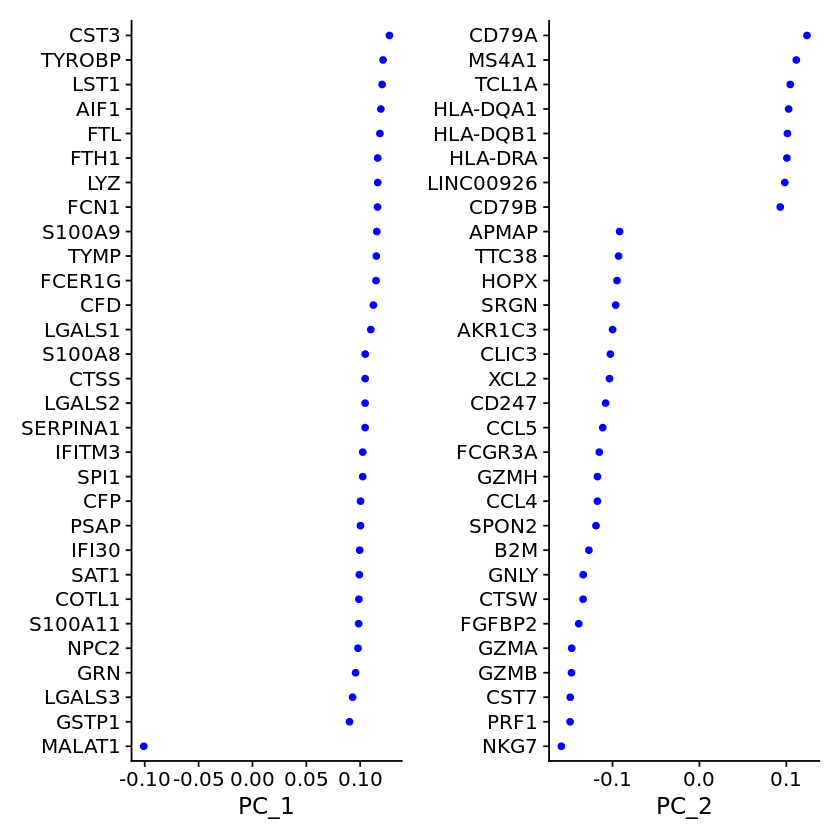

In [107]:
VizDimLoadings(pbmc.filt.norm.scaled.PCA, dims = 1:2, reduction = "pca")

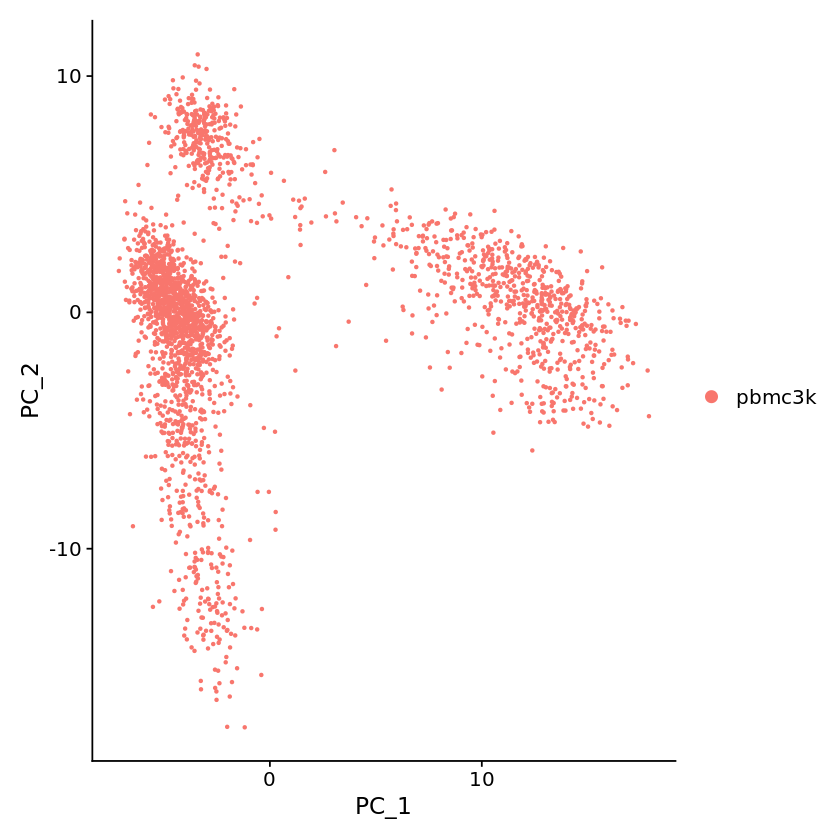

In [108]:
DimPlot(pbmc.filt.norm.scaled.PCA, reduction = "pca")

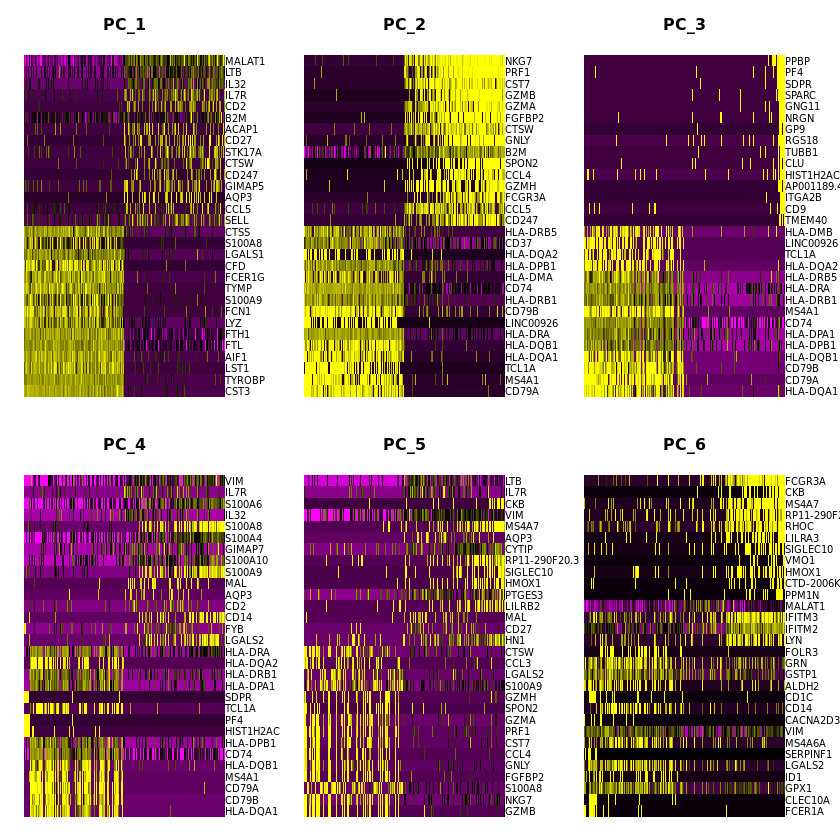

In [109]:
DimHeatmap(pbmc.filt.norm.scaled.PCA, dims = 1:6, cells = 500, balanced = TRUE)

## Determine the ‘dimensionality’ of the dataset

In [110]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc.filt.norm.scaled.PCA, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc.filt.norm.scaled.PCA, dims = 1:20)

ERROR: Error in pAll[, dims, drop = FALSE]: subscript out of bounds


In [ ]:
pbmc.JackStraw <- JackStraw(pbmc.filt.norm.scaled.PCA, dims = 50)
pbmc.ScoreJackStraw <- ScoreJackStraw(pbmc.JackStraw, dims = 1:50)

In [ ]:
JackStrawPlot(pbmc.ScoreJackStraw, dims = 1:10)

In [ ]:
ElbowPlot(pbmc.filt.norm.scaled.PCA)

## Cluster the cells

In [ ]:
pbmc.graph <- FindNeighbors(pbmc.filt.norm.scaled.PCA, dims = 1:10)
pbmc.clusters <- FindClusters(pbmc.neighbors, resolution = 0.5)

## Run non-linear dimensional reduction (UMAP/tSNE)

In [ ]:
reticulate::py_install(packages = 'umap-learn')

In [ ]:
pbmc.UMAP <- RunUMAP(pbmc.filt.norm.scaled.PCA, dims = 1:6)

In [ ]:
DimPlot(pbmc.UMAP, reduction = "umap")

In [ ]:
pbmc.UMAP